# Requirements

In [1]:
# Import required modules
import os
import toml
import zipfile
import numpy
import pyKVFinder
import nglview
import IPython

In [2]:
# Unzip required files
if not os.path.isdir('./data'):
    with zipfile.ZipFile('./data.zip', 'r') as zipped:
        zipped.extractall('./data')

In [3]:
# Get DALI proteins
pdbs = [f for f in sorted(os.listdir('./data')) if f.endswith('.pdb')]
print(pdbs)

# Get reference protein
reference = './data/6WEN-A.pdb'

['2ACF-B.pdb', '2VRI-A.pdb', '2X47-A.pdb', '3EJG-A.pdb', '3ETI-B.pdb', '5HIH-A.pdb', '6WEN-A.pdb', '6Y73-D.pdb']


In [4]:
# Define a common custom box using parKVFinder's PyMOL plugin
box = {
    'box':{
        'p1': [ 3.53, -0.87, 9.21,],
        'p2': [ 17.33, -0.87, 9.21,],
        'p3': [ 3.53, 14.73, 9.21,],
        'p4': [ 3.53, -0.87, 28.72,],
    }
}

# Write common custom box to file
with open('box.toml', 'w') as f:
    toml.dump(box, f)

# Cavity detection and characterization on reference

In [5]:
# Detect and characterize cavities on reference
results = pyKVFinder.pyKVFinder(reference, probe_out=12.0, volume_cutoff=100.0, box='./box.toml', ignore_backbone=True, include_depth=True, include_hydropathy=True)

# Export cavities and results
results.export_all(fn='./results/6WEN/6WEN.results.toml', output='./results/6WEN/6WEN.output.pdb', output_hydropathy='./results/6WEN/6WEN.EisenbergWeiss.pdb', include_frequencies_pdf=True, pdf='./results/6WEN/6WEN.histograms.pdf')

In [6]:
# Visualize interface residues (red licorice)

# Define the tag of the cavity you want to see 
tag = 'KAA'

# Create NGL Viewer widget
view = nglview.NGLWidget()

# Add protein
p1 = view.add_component(reference)
p1.clear()
p1.add_cartoon(color='grey')

# Select interface residues
selection = f"{' or '.join([f'({sel[0]} and :{sel[1]})' for sel in results.residues[tag]])}"

# Add interface residues
p1.add_licorice(color='red', selection=selection)

# Add cavities
p2 = view.add_component('./results/6WEN/6WEN.output.pdb')
p2.clear()
p2.add_surface(color='white', opacity=0.5, surfaceType='vws', probeRadius=0.3)

# Show
view

NGLWidget()

In [7]:
# Visualize depth of cavity points (rainbow scale)

# Create NGL Viewer widget
view = nglview.NGLWidget()

# Add protein
p1 = view.add_component(reference)
p1.clear()
p1.add_cartoon(color='grey')

# Add depth cavities
p3 = view.add_component('./results/6WEN/6WEN.output.pdb')
p3.clear()
p3.add_surface(colorScheme='bfactor', colorScale='rainbow', colorReverse=True, surfaceType='vws', probeRadius=0.3)

# Show
view

NGLWidget()

In [8]:
# Visualize hydropathy of cavity points (yellow-white-blue scale)

# Create NGL Viewer widget
view = nglview.NGLWidget()

# Add protein
p1 = view.add_component(reference)
p1.clear()
p1.add_cartoon(color='grey')

# Add hydrophobicity scale cavities
p4 = view.add_component('./results/6WEN/6WEN.EisenbergWeiss.pdb')
p4.clear()
p4.add_surface(colorScheme='bfactor', colorMode='rgb', colorScale=[0xFFFF00, 0xffffff, 0x0000FF], surfaceType='vws', probeRadius=0.3)

# Show
view

NGLWidget()

In [9]:
# Display histograms of residues
IPython.display.IFrame("./results/6WEN/6WEN.histograms.pdf", width=600, height=300)

# Occurence analysis

In [10]:
# Read van der Waals dictionary
vdw = pyKVFinder.read_vdw()

# Create empty array
occurrence = None

for pdb in pdbs:
    # Load atomic coordinates and information
    resinfo, xyzr = pyKVFinder.read_pdb(os.path.join('./data', pdb), vdw)
    
    # Get grid from file
    vertices, resinfo, xyzr, sincos, nx, ny, nz = pyKVFinder.get_grid_from_file('./box.toml', resinfo, xyzr, probe_out=12.0)
    
    # Detect biomolecular cavities
    ncav, cavities = pyKVFinder.detect(nx, ny, nz, xyzr, vertices, sincos, probe_out=12.0, volume_cutoff=100.0, box_adjustment=True)
    
    if occurrence is None:
        occurrence = (cavities > 1).astype(int)
    else:
        occurrence += (cavities > 1).astype(int)

# Get cavity points
cavities = ((occurrence > 1).astype('int32'))
cavities += cavities

# Export cavities with percentage of occurrence in B-factor column
pyKVFinder.export('./results/occurence.pdb', cavities, None, vertices, sincos, ncav=1, B=occurrence) 

In [11]:
# Visualize the occurrence of cavity points throughout the simulation

# Create NGL Viewer widget
view = nglview.NGLWidget()

# Disply referece 6W02 as grey cartoon
pdb = view.add_component(reference)
pdb.clear()
pdb.add_cartoon(color='grey', opacity=0.5)

# Display surface points colored by hydrophobicity
cavs = view.add_component('./results/occurence.pdb')
cavs.clear()
cavs.add_point(colorScheme='bfactor',colorScale='rainbow', colorReverse=True)

# Display on NGL viewer
view

NGLWidget()

# Hydropathy analysis

In [12]:
# Read van der Waals dictionary
vdw = pyKVFinder.read_vdw()

# hydropathy
hydropathy = {}
frequency = {}

for pdb in pdbs:
    # Load atomic coordinates and information
    resinfo, xyzr = pyKVFinder.read_pdb(os.path.join('./data', pdb), vdw)
    
    # Get grid from file
    vertices, resinfo, xyzr, sincos, nx, ny, nz = pyKVFinder.get_grid_from_file('./box.toml', resinfo, xyzr, probe_out=12.0)
    
    # Detect biomolecular cavities
    ncav, cavities = pyKVFinder.detect(nx, ny, nz, xyzr, vertices, sincos, probe_out=12.0, volume_cutoff=100.0, box_adjustment=True)

    # Constitutional characterization
    residues = pyKVFinder.constitutional(cavities, resinfo, xyzr, vertices, sincos, ncav, ignore_backbone=True)
    frequencies = pyKVFinder.calculate_frequencies(residues)
    
    # Accumulate frequency
    frequency[f"{pdb.replace('.pdb', '')}"] = frequencies['KAA']['RESIDUES']
    
    # Depth characterization
    depths, max_depth, avg_depth = pyKVFinder.depth(cavities, ncav)
    
    # Spatial characterization
    surface, volume, area = pyKVFinder.spatial(cavities, ncav)
    
    # Hydropathy characterization
    scales, avg_hydropathy = pyKVFinder.hydropathy(surface, resinfo, xyzr, vertices, sincos, ncav, ignore_backbone=True)
    
    # Accumulate hydropathy arrays
    hydropathy[f"{pdb.replace('.pdb', '')}"] = scales.reshape(-1)
    
    # Export cavities
    output_cavity = f"./results/detections/{pdb.replace('.pdb', '')}.cavities.pdb"
    output_hydropathy = f"./results/detections/{pdb.replace('.pdb', '')}.EisenbergWeiss.pdb"
    pyKVFinder.export(output_cavity, cavities, surface, vertices, sincos, ncav=ncav, output_hydropathy=output_hydropathy, scales=scales)
    
    # Write results
    output_results = f"./results/detections/{pdb.replace('.pdb', '')}.results.toml"
    pyKVFinder.write_results(output_results, pdb=pdb, ligand=None, output=output_cavity, output_hydropathy=output_hydropathy, volume=volume, area=area, max_depth=max_depth, avg_depth=avg_depth, avg_hydropathy=avg_hydropathy, residues=residues, frequencies=frequencies)

## Data analysis

In [13]:
# Import required packages
import scipy
from scipy.cluster.hierarchy import dendrogram, linkage
import pandas as pd
import matplotlib.pyplot as plt

## Hydropathy distributions

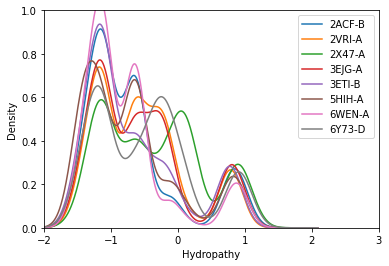

In [14]:
# Plot kde distributions
data = pd.DataFrame(hydropathy).replace(0.0, numpy.nan)
ax = data.plot.kde()
ax.set_xlim(-2, 3)
ax.set_ylim(0, 1)
ax.set_xlabel('Hydropathy')

# Save to file
fig = ax.get_figure()
os.mkdir('./results/plots') if not os.path.exists('./results/plots') else None
fig.savefig('./results/plots/kde.png', dpi=300)

## Hierarchical clustering

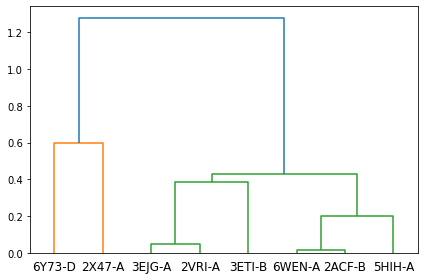

In [15]:
# Hierarchical clustering of residues frequency

# Prepare data
data = pd.DataFrame.from_dict(frequency, orient='index').replace(numpy.nan, 0.0)

# Calculate distances
linked = linkage(data, method='complete', metric='correlation')

# Create dendogram
scipy.cluster.hierarchy.dendrogram(linked, orientation='top', labels=data.index, distance_sort='descending', show_leaf_counts=True)

# Save to file
plt.tight_layout()
plt.savefig('./results/plots/dendogram.png', dpi=300)